# Set Up

In [23]:
# Loading the packages
import requests # For making HTTP requests to fetch data
import pandas as pd # For data manipulation and analysis (DataFrames)
import matplotlib.pyplot as plt # For creating plots and visualizations
import seaborn as sns # For enhanced statistical data visualizations
import numpy as np # For numerical operations
import logging # For logging events and errors
from typing import Optional # For type hinting, indicating a value can be a type or None
from typing import Dict # For type hinting dictionaries
from typing import List, Tuple # For type hinting lists and tuples
from sklearn.ensemble import RandomForestClassifier # Machine learning model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score # For evaluating model performance
from sklearn.model_selection import RandomizedSearchCV # For hyperparameter tuning
from sklearn.linear_model import LogisticRegression # Machine learning model
from sklearn.tree import DecisionTreeClassifier # Machine learning model
from xgboost import XGBClassifier # Machine learning model
from sklearn.neural_network import MLPClassifier # Machine learning model (Feed Forward Neural Network)
from sklearn.tree import plot_tree # Visualizing decision trees

# Data Gathering

In [24]:
# Setup logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

def fetch_crypto_price(coin_id: str, days: int = 365, vs_currency: str = "usd", interval: str = "daily") -> Optional[pd.DataFrame]:
    """
    Fetch historical price data for a given cryptocurrency using the CoinGecko API.

    Args:
        coin_id (str): The CoinGecko ID of the cryptocurrency (e.g., "bitcoin", "ethereum").
        days (int): Number of past days to retrieve data for.
        vs_currency (str): The fiat currency to compare against.
        interval (str): Data interval (e.g., "daily").

    Returns:
        pd.DataFrame: DataFrame with timestamp and price columns, or None if an error occurs.
    """
    # Construct the API URL
    url = f"https://api.coingecko.com/api/v3/coins/{coin_id}/market_chart"
    # Define parameters for the API request
    params = {
        "vs_currency": vs_currency,
        "days": str(days),
        "interval": interval
    }

    try:
        # Make the GET request to the CoinGecko API
        response = requests.get(url, params=params)
        # Raise an HTTPError for bad responses (4xx or 5xx)
        response.raise_for_status()
        # Parse the JSON response
        data = response.json()
        # Create a pandas DataFrame from the 'prices' data
        df = pd.DataFrame(data["prices"], columns=["timestamp", "price"])
        # Convert the timestamp from milliseconds to datetime objects
        df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
        # Return the DataFrame
        return df
    except requests.RequestException as e:
        # Log an error if the request fails
        logging.error(f"Failed to fetch data for {coin_id}: {e}")
        # Return None to indicate failure
        return None


def main():
    # Define the coins to fetch
    coins = ["bitcoin", "ethereum", "ripple", "solana"]
    # Dictionary to store the fetched data DataFrames
    crypto_data = {}

    # Loop through each coin
    for coin in coins:
        # Fetch data for the current coin
        df = fetch_crypto_price(coin)
        # Check if data was successfully fetched
        if df is not None:
            # Log the number of records fetched
            logging.info(f"Fetched {len(df)} records for {coin}.")
            # Print the head of the DataFrame for verification
            print(df.head())
            # Store the DataFrame in the dictionary
            crypto_data[coin] = df
        else:
            # Log a warning if no data was returned
            logging.warning(f"No data returned for {coin}.")

    # Return the dictionary containing all crypto data
    return crypto_data


# Execute the main function when the script is run directly
if __name__ == "__main__":
    crypto_data = main()

   timestamp         price
0 2024-07-10  57988.303512
1 2024-07-11  57704.202284
2 2024-07-12  57388.192479
3 2024-07-13  57899.288957
4 2024-07-14  59152.719139
   timestamp        price
0 2024-07-10  3064.092361
1 2024-07-11  3099.710186
2 2024-07-12  3102.090230
3 2024-07-13  3132.980839
4 2024-07-14  3173.504234
   timestamp     price
0 2024-07-10  0.435768
1 2024-07-11  0.438883
2 2024-07-12  0.449315
3 2024-07-13  0.475004
4 2024-07-14  0.526840
   timestamp       price
0 2024-07-10  141.457067
1 2024-07-11  141.922657
2 2024-07-12  136.074132
3 2024-07-13  139.362193
4 2024-07-14  141.675244


### 🧩 Data Gathering – Fetching Historical Cryptocurrency Prices

In this section, we gather historical daily price data for selected cryptocurrencies using the CoinGecko API.

**Key steps:**

- **Logging Setup**: Enables logging to track info and error messages during data retrieval.
- **Function `fetch_crypto_price`**:
  - Inputs: cryptocurrency ID (e.g., `"bitcoin"`), number of days (default: 365), comparison currency (default: `"usd"`), and interval (`"daily"`).
  - Sends a GET request to the CoinGecko API.
  - Parses the JSON response to extract price data.
  - Converts timestamps to `datetime` format.
  - Returns a `pandas.DataFrame` with two columns: `timestamp` and `price`.

- **Main Routine**:
  - Defines a list of coins: `["bitcoin", "ethereum", "ripple", "solana"]`.
  - Fetches price data for each coin.
  - Logs the number of records retrieved and prints a preview (`df.head()`).
  - Stores the results in a dictionary `crypto_data` for use in later stages.

> This forms the data foundation for subsequent preprocessing, modeling, and analysis steps.


# Exploratory Data Analysis

   timestamp         price
0 2024-07-10  57988.303512
1 2024-07-11  57704.202284
2 2024-07-12  57388.192479
3 2024-07-13  57899.288957
4 2024-07-14  59152.719139
   timestamp        price
0 2024-07-10  3064.092361
1 2024-07-11  3099.710186
2 2024-07-12  3102.090230
3 2024-07-13  3132.980839
4 2024-07-14  3173.504234


ERROR:root:Failed to fetch data for ripple: 429 Client Error: Too Many Requests for url: https://api.coingecko.com/api/v3/coins/ripple/market_chart?vs_currency=usd&days=365&interval=daily


   timestamp       price
0 2024-07-10  141.457067
1 2024-07-11  141.922657
2 2024-07-12  136.074132
3 2024-07-13  139.362193
4 2024-07-14  141.675244


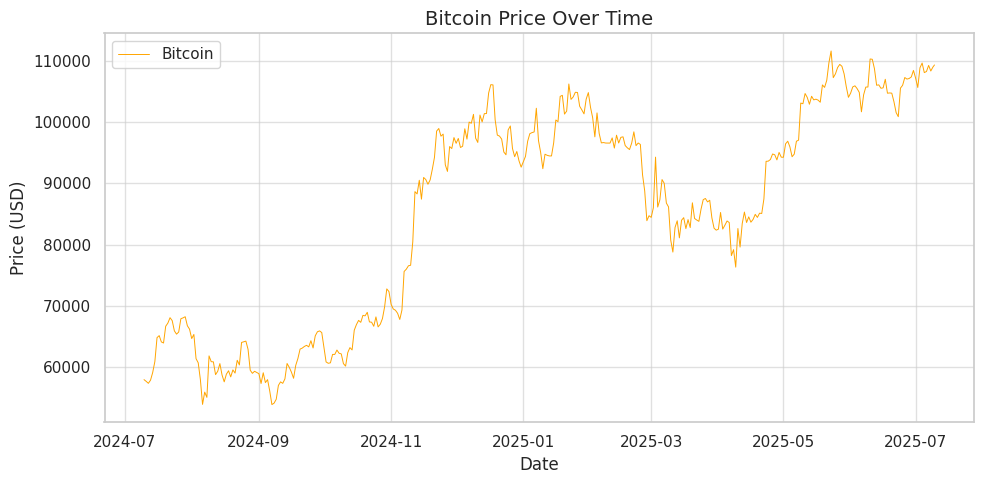

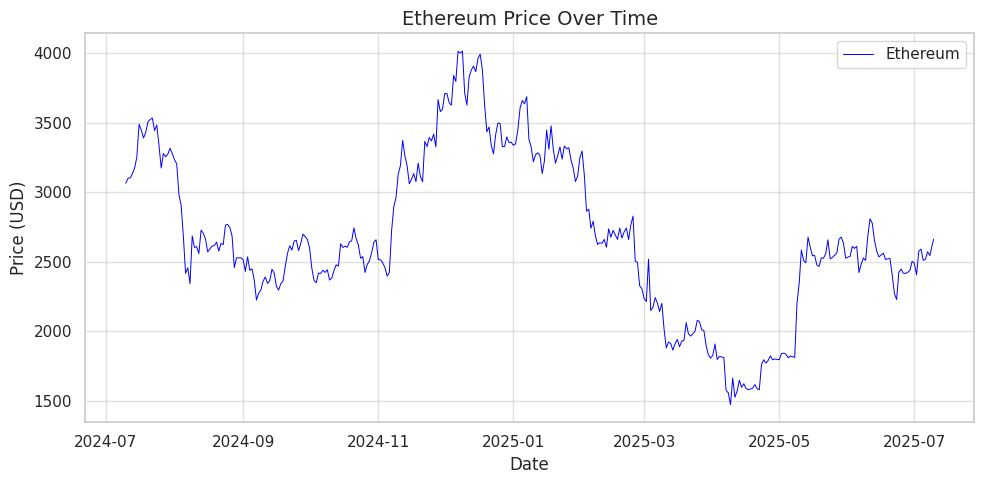

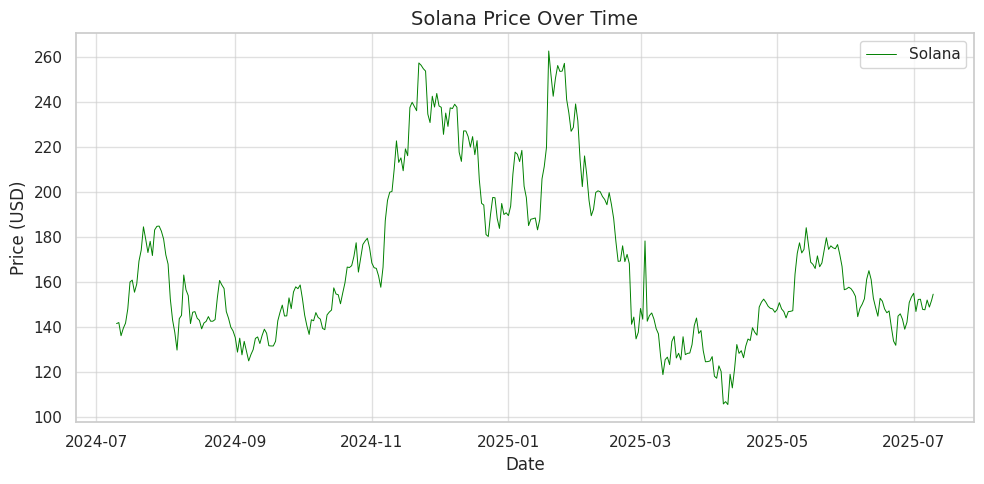

In [25]:
def plot_crypto_price(data: pd.DataFrame, coin_name: str, color: str = 'blue') -> None:
    """
    Plot the price of a cryptocurrency over time.

    Args:
        data (pd.DataFrame): DataFrame containing 'timestamp' and 'price'.
        coin_name (str): Name of the cryptocurrency (used as title/label).
        color (str): Color of the plot line.
    """
    # Check if the DataFrame is None or empty
    if data is None or data.empty:
        print(f"No data available to plot for {coin_name}.")
        return

    # Create a new figure for the plot
    plt.figure(figsize=(10, 5))
    # Plot the price over time
    plt.plot(data['timestamp'], data['price'], label=coin_name, color=color, linewidth=0.7)

    # Set the title of the plot
    plt.title(f'{coin_name} Price Over Time', fontsize=14)
    # Set the x-axis label
    plt.xlabel('Date', fontsize=12)
    # Set the y-axis label
    plt.ylabel('Price (USD)', fontsize=12)
    # Add a grid to the plot
    plt.grid(True, alpha=0.6)
    # Add a legend to the plot
    plt.legend()
    # Adjust layout to prevent labels overlapping
    plt.tight_layout()
    # Display the plot
    plt.show()


def plot_all_cryptos(crypto_data: Dict[str, pd.DataFrame]) -> None:
    """
    Plot multiple cryptocurrencies from a dictionary of coin name -> DataFrame.

    Args:
        crypto_data (Dict[str, pd.DataFrame]): Dictionary of coin data.
    """
    # Define a color map for different cryptocurrencies
    color_map = {
        'bitcoin': 'orange',
        'ethereum': 'blue',
        'ripple': 'purple',
        'solana': 'green'
    }

    # Iterate through the dictionary of crypto data
    for coin, df in crypto_data.items():
        # Plot the price for each cryptocurrency, using the defined color map
        plot_crypto_price(df, coin.capitalize(), color=color_map.get(coin.lower(), 'gray'))


# Example usage if you're continuing from the previous script
if __name__ == "__main__":
    # Fetch the data by calling the main function from the previous script
    crypto_data = main()  # from the previous script
    # Plot all the fetched cryptocurrencies
    plot_all_cryptos(crypto_data)

### 📊 Exploratory Data Analysis (EDA) – Visualizing Cryptocurrency Prices

In this section, we perform a visual exploration of the historical price data gathered earlier.

**Key Components:**

- **Function `plot_crypto_price`**:
  - Plots the price of a single cryptocurrency over time.
  - Accepts a `pandas.DataFrame` with `timestamp` and `price`, a coin name, and an optional plot color.
  - Includes useful plot features like titles, axis labels, grid, and legend for clarity.

- **Function `plot_all_cryptos`**:
  - Iterates through the dictionary `crypto_data` (from Part 1).
  - Uses predefined colors to generate individual time series plots for each coin:  
    - Bitcoin: orange  
    - Ethereum: blue  
    - Ripple: purple  
    - Solana: green
  - Calls `plot_crypto_price` for each cryptocurrency.

> These visualizations help identify trends, volatility, and general behavior of each cryptocurrency over time.


# Feature Engineering

In [26]:
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add technical indicators and rolling features to a cryptocurrency price DataFrame.

    Features:
        - MA_2: 2-day moving average
        - MA_4: 4-day moving average
        - Volatility_3: 3-day rolling standard deviation
        - RSI_3: Relative Strength Index with 3-day window
        - MACD: Moving Average Convergence Divergence (12/26 EMA)
        - Signal_Line: MACD Signal Line (9 EMA)

    Args:
        df (pd.DataFrame): Must contain 'price' column.

    Returns:
        pd.DataFrame: Original DataFrame with new features added.
    """

    # Check if the 'price' column exists in the DataFrame
    if 'price' not in df.columns:
        raise ValueError("DataFrame must contain a 'price' column.")

    # Create a copy of the DataFrame to avoid modifying the original
    df = df.copy()

    # Moving averages
    # Calculate the 2-day rolling mean of the 'price'
    df['MA_2'] = df['price'].rolling(window=2).mean()
    # Calculate the 4-day rolling mean of the 'price'
    df['MA_4'] = df['price'].rolling(window=4).mean()

    # Volatility
    # Calculate the 3-day rolling standard deviation of the 'price'
    df['Volatility_3'] = df['price'].rolling(window=3).std()

    # RSI calculation (3-day)
    def compute_rsi(series: pd.Series, period: int = 3) -> pd.Series:
        # Calculate the difference in price from the previous day
        delta = series.diff()
        # Calculate gains (positive price changes)
        gain = delta.clip(lower=0)
        # Calculate losses (negative price changes)
        loss = -delta.clip(upper=0)
        # Calculate the average gain over the specified period
        avg_gain = gain.rolling(window=period).mean()
        # Calculate the average loss over the specified period
        avg_loss = loss.rolling(window=period).mean()
        # Calculate the Relative Strength (RS)
        rs = avg_gain / avg_loss
        # Calculate the Relative Strength Index (RSI)
        return 100 - (100 / (1 + rs))

    # Compute the 3-day RSI and add it as a new column
    df['RSI_3'] = compute_rsi(df['price'], period=3)

    # MACD and Signal Line
    # Calculate the 12-day Exponential Moving Average (EMA)
    ema_short = df['price'].ewm(span=12, adjust=False).mean()
    # Calculate the 26-day Exponential Moving Average (EMA)
    ema_long = df['price'].ewm(span=26, adjust=False).mean()
    # Calculate the Moving Average Convergence Divergence (MACD)
    df['MACD'] = ema_short - ema_long
    # Calculate the 9-day EMA of the MACD (Signal Line)
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # Return the DataFrame with the added features
    return df

In [27]:
# Add features to the ethereum data if available
if 'ethereum' in crypto_data:
    eth_data = add_features(crypto_data['ethereum'])
else:
    print("ethereum not found in crypto_data")
# Add features to the bitcoin data if available
if 'bitcoin' in crypto_data:
    btc_data = add_features(crypto_data['bitcoin'])
else:
    print("bitcoin not found in crypto_data")
# Add features to the ripple data if available
if 'ripple' in crypto_data:
    xrp_data = add_features(crypto_data['ripple'])
else:
    print("ripple not found in crypto_data")
# Add features to the solana data if available
if 'solana' in crypto_data:
    sol_data = add_features(crypto_data['solana'])
else:
    print("solana not found in crypto_data")

ripple not found in crypto_data


In [28]:
def create_target_and_clean(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create a binary target variable based on whether the price increased from the previous day.
    Drops rows with any NaN values (e.g., from moving averages or other lag features).

    Args:
        df (pd.DataFrame): DataFrame with a 'price' column.

    Returns:
        pd.DataFrame: Cleaned DataFrame with 'target' column.
    """
    # Create a copy of the DataFrame to avoid modifying the original
    df = df.copy()
    # Create the 'target' column: 1 if price increased from previous day, 0 otherwise
    df['target'] = (df['price'] > df['price'].shift(1)).astype(int)
    # Drop any rows that contain NaN values (introduced by rolling averages, diff, etc.)
    return df.dropna()

# Create target and clean the bitcoin data
btc_data = create_target_and_clean(btc_data)
# Create target and clean the ethereum data
eth_data = create_target_and_clean(eth_data)
# Create target and clean the ripple data
xrp_data = create_target_and_clean(xrp_data)
# Create target and clean the solana data
sol_data = create_target_and_clean(sol_data)

### 🛠️ Feature Engineering – Technical Indicators & Target Creation

In this section, we enhance the raw price data by engineering meaningful features and creating a target variable suitable for supervised learning.

**1. Technical Indicators:**

Using a custom function, we compute several technical indicators that capture trends, momentum, and volatility in the price time series:

- `MA_2` and `MA_4`: 2-day and 4-day moving averages
- `Volatility_3`: 3-day rolling standard deviation
- `RSI_3`: Relative Strength Index over 3 days
- `MACD`: Difference between 12-day and 26-day exponential moving averages
- `Signal_Line`: 9-day EMA of the MACD

These indicators are added to each cryptocurrency’s dataset using the `add_features()` function.

**2. Target Variable Creation:**

To enable binary classification (e.g., predicting whether the price will increase), we define a binary `target`:

- `target = 1` if the price increased compared to the previous day
- `target = 0` otherwise

This is done using the `create_target_and_clean()` function, which also removes rows containing `NaN` values introduced by rolling computations.


# Data Splitting

In [29]:
def split_by_date(dfs: List[pd.DataFrame], split_date: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split multiple DataFrames into train and test sets based on a date.

    Args:
        dfs (List[pd.DataFrame]): List of DataFrames to split (must contain 'timestamp' column).
        split_date (str): Date string in 'YYYY-MM-DD' format.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: (train_df, test_df) concatenated from all input DataFrames.
    """
    # Create a list of DataFrames for the training set (timestamps before the split date)
    train_parts = [df[df['timestamp'] < split_date] for df in dfs]
    # Create a list of DataFrames for the test set (timestamps on or after the split date)
    test_parts = [df[df['timestamp'] >= split_date] for df in dfs]

    # Concatenate the training DataFrames into a single DataFrame
    train_df = pd.concat(train_parts, ignore_index=True)
    # Concatenate the test DataFrames into a single DataFrame
    test_df = pd.concat(test_parts, ignore_index=True)

    # Return the training and test DataFrames
    return train_df, test_df

# Split the data into training and test sets using the specified split date
train_df, test_df = split_by_date(
    [btc_data, eth_data, xrp_data, sol_data],
    split_date='2025-04-15'
)

# Print the shapes of the training and test DataFrames
print(train_df.shape)
print(test_df.shape)
# Print the total number of rows to verify the split
print(train_df.shape[0] + test_df.shape[0])

(1104, 10)
(348, 10)
1452


In [30]:
def print_class_distribution(df: pd.DataFrame, name: str) -> None:
    """
    Print class counts and proportion of '1's in the 'target' column for a given DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing a 'target' column.
        name (str): Name of the dataset (e.g., 'Train', 'Test').
    """
    # Print the name of the DataFrame
    print(f'{name} df:')
    # Get the counts of each class in the 'target' column
    class_counts = df['target'].value_counts()
    # Print the class counts
    print(class_counts)

    # Calculate the proportion of the '1' class (price increase)
    share_increase = class_counts.get(1, 0) / class_counts.sum()
    # Print the share of increasing targets, formatted as a percentage
    print(f'Share of increasing targets: {share_increase:.2%}\n')

# Print target distributions for the training set
print_class_distribution(train_df, "Train")
# Print target distributions for the test set
print_class_distribution(test_df, "Test")

Train df:
target
1    558
0    546
Name: count, dtype: int64
Share of increasing targets: 50.54%

Test df:
target
1    184
0    164
Name: count, dtype: int64
Share of increasing targets: 52.87%



In [31]:
# Define the list of feature columns to be used for training
feature_cols = ['MA_2', 'MA_4', 'Volatility_3', 'RSI_3', 'MACD', 'Signal_Line']

# Create the feature matrix (X) for the training set
X_train = train_df[feature_cols]
# Create the target vector (y) for the training set (using .values ensures a 1D numpy array which is often required by sklearn)
y_train = train_df['target']  # Use 1D array for compatibility with sklearn

# Create the feature matrix (X) for the test set
X_test = test_df[feature_cols]
# Create the target vector (y) for the test set
y_test = test_df['target']

### 🔀 Data Splitting and Preparation for Modeling

In this section, we split the engineered datasets into training and test sets based on a specific date to ensure a realistic temporal separation for model evaluation.

**Steps:**

- **Function `split_by_date()`**:  
  Accepts a list of DataFrames (one per cryptocurrency) and splits each into training and test subsets based on the `timestamp` column using a given cutoff date (`2025-04-15`).  
  Training data includes all records before the split date; test data includes records on and after the split date.  
  The split parts are then concatenated into unified training and test DataFrames.

- **Class Distribution Check**:  
  The `print_class_distribution()` function prints the counts of the binary target classes (`0` for price decrease or no change, `1` for increase) and their proportion within each dataset to check for class balance.

- **Feature and Target Matrix Construction**:  
  Defines the feature columns derived from technical indicators (`MA_2`, `MA_4`, `Volatility_3`, `RSI_3`, `MACD`, `Signal_Line`).  
  Constructs feature matrices `X_train`, `X_test` and target vectors `y_train`, `y_test` ready for machine learning model training and evaluation.

---

This setup ensures that the models are trained on past data and evaluated on unseen future data, preserving temporal integrity.


# Model Selection

In [32]:
# Model hyperparameter grids for tuning using RandomizedSearchCV
param_grids = {
    'logistic_regression': {
        'C': np.logspace(-4, 4, 20), # Regularization strength
        'penalty': ['l2'], # Type of regularization penalty
        'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'] # Algorithm to use for optimization
    },
    'decision_tree': {
        'max_depth': np.arange(1, 100), # Maximum depth of the tree
        'min_samples_split': np.arange(10, 100), # Minimum number of samples required to split an internal node
        'min_samples_leaf': np.arange(5, 100), # Minimum number of samples required to be at a leaf node
        'criterion': ['gini', 'entropy'] # Function to measure the quality of a split
    },
    'random_forest': {
        'n_estimators': np.arange(100, 1001, 100), # Number of trees in the forest
        'max_depth': np.arange(1, 100), # Maximum depth of the trees
        'min_samples_split': np.arange(10, 100), # Minimum number of samples required to split an internal node
        'min_samples_leaf': np.arange(5, 100), # Minimum number of samples required to be at a leaf node
        'max_features': ['sqrt', 'log2'] # Number of features to consider when looking for the best split
    },
    'xgboost': {
        'n_estimators': np.arange(100, 1001, 100), # Number of boosting rounds (trees)
        'max_depth': np.arange(1, 11), # Maximum depth of a tree
        'learning_rate': np.logspace(-4, -1, 10), # Step size shrinkage used in update to prevent overfitting
        'subsample': [0.6, 0.8, 1.0] # Fraction of samples used to train each tree
    },
    'mlp': {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)], # The ith element represents the number of neurons in the ith hidden layer
        'activation': ['tanh', 'relu'], # Activation function for the hidden layer
        'solver': ['adam', 'sgd'], # The solver for weight optimization
        'learning_rate': ['constant', 'adaptive'] # Learning rate schedule for weight updates
    }
}

In [33]:
# Dictionaries to store evaluation results for accuracy and precision
accuracy_results = {'Model': [], 'Train Accuracy': [], 'Test Accuracy': []}
precision_results = {'Model': [], 'Train Precision': [], 'Test Precision': []}

def tune_evaluate_and_store_results(model, param_grid, model_name, X_train, y_train, X_test, y_test, n_iter=10, cv=5):
    """
    Performs randomized hyperparameter tuning, evaluates the best model, and stores results.

    Args:
        model: The scikit-learn model to tune.
        param_grid: The dictionary of hyperparameters to search.
        model_name (str): The name of the model.
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training target.
        X_test (pd.DataFrame): Test features.
        y_test (pd.Series): Test target.
        n_iter (int): Number of parameter settings that are sampled.
        cv (int): Number of folds in cross-validation.

    Returns:
        The best estimator found by RandomizedSearchCV.
    """
    # Perform RandomizedSearchCV to find the best hyperparameters
    search = RandomizedSearchCV(model, param_grid, scoring='precision', cv=cv, n_iter=n_iter, n_jobs=-1, verbose=1)
    # Fit the RandomizedSearchCV to the training data
    search.fit(X_train, y_train)
    # Get the best model found during the search
    best_model = search.best_estimator_

    # Make predictions on the training and test sets using the best model
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    # Calculate evaluation metrics
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    # Calculate weighted precision for handling potential class imbalance
    train_precision = precision_score(y_train, y_train_pred, average='weighted')
    test_precision = precision_score(y_test, y_test_pred, average='weighted')

    # Store the calculated metrics in the results dictionaries
    accuracy_results['Model'].append(model_name)
    accuracy_results['Train Accuracy'].append(train_accuracy)
    accuracy_results['Test Accuracy'].append(test_accuracy)

    precision_results['Model'].append(model_name)
    precision_results['Train Precision'].append(train_precision)
    precision_results['Test Precision'].append(test_precision)

    # Print the optimal hyperparameters found for the model
    print(f'Optimal parameters for {model_name}: {search.best_params_}')

    # Return the best trained model
    return best_model

In [34]:
# Define a list of tuples, each containing a model instance, its parameter grid, and its name
models_to_run = [
    (LogisticRegression(max_iter=1000), param_grids['logistic_regression'], "Logistic Regression"),
    (DecisionTreeClassifier(), param_grids['decision_tree'], "Decision Tree"),
    (RandomForestClassifier(), param_grids['random_forest'], "Random Forest"),
    (XGBClassifier(eval_metric='logloss'), param_grids['xgboost'], "XGBoost"),
    (MLPClassifier(max_iter=500), param_grids['mlp'], "Feed Forward NN"),
]

# Dictionary to store the best trained model for each type
best_models = {}

# Iterate through the list of models to run
for model, param_grid, name in models_to_run:
    # Print a message indicating which model is being trained
    print(f"Training {name}...")
    # Tune, evaluate, and store results for the current model
    # Store the best trained model in the best_models dictionary
    best_models[name] = tune_evaluate_and_store_results(model, param_grid, name, X_train, y_train, X_test, y_test)

Training Logistic Regression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.11/dist-packages/scipy/optimize/_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/optimize.py:100: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(


Optimal parameters for Logistic Regression: {'solver': 'newton-cg', 'penalty': 'l2', 'C': np.float64(3792.690190732246)}
Training Decision Tree...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Optimal parameters for Decision Tree: {'min_samples_split': np.int64(55), 'min_samples_leaf': np.int64(53), 'max_depth': np.int64(44), 'criterion': 'gini'}
Training Random Forest...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Optimal parameters for Random Forest: {'n_estimators': np.int64(600), 'min_samples_split': np.int64(16), 'min_samples_leaf': np.int64(16), 'max_features': 'sqrt', 'max_depth': np.int64(78)}
Training XGBoost...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Optimal parameters for XGBoost: {'subsample': 0.8, 'n_estimators': np.int64(800), 'max_depth': np.int64(4), 'learning_rate': np.float64(0.002154434690031882)}
Training Feed Forward NN...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Optimal parameters for Feed Fo

### 🤖 Model Selection and Hyperparameter Tuning

In this section, multiple machine learning models are trained and optimized using randomized hyperparameter search to predict the binary target variable.

**Models Included:**

- Logistic Regression
- Decision Tree
- Random Forest
- XGBoost
- Feed Forward Neural Network (MLP)

**Process:**

- Defined hyperparameter grids specific to each model, covering key parameters such as regularization strength, tree depth, number of estimators, learning rates, and network architecture.
- Used `RandomizedSearchCV` with 5-fold cross-validation to efficiently explore hyperparameter combinations, optimizing for weighted precision to handle class imbalance.
- For each model, the best hyperparameters were identified, and performance metrics (accuracy and precision) were computed on both training and test sets.
- Results (accuracy and precision) are stored for easy comparison across models.
- The best estimator for each model is saved for downstream evaluation.

> This systematic tuning ensures models are well-calibrated and maximizes their predictive performance on unseen data.


## Results

In [35]:
# Convert the dictionaries storing results into pandas DataFrames for easier display
accuracy_df = pd.DataFrame(accuracy_results)
precision_df = pd.DataFrame(precision_results)

# Display the accuracy results table
print("Accuracy Results Table")
print(accuracy_df)

# Display the precision results table
print("\nPrecision Results Table")
print(precision_df)

Accuracy Results Table
                 Model  Train Accuracy  Test Accuracy
0  Logistic Regression        0.690217       0.655172
1        Decision Tree        0.721014       0.637931
2        Random Forest        0.764493       0.655172
3              XGBoost        0.734601       0.658046
4      Feed Forward NN        0.575181       0.540230

Precision Results Table
                 Model  Train Precision  Test Precision
0  Logistic Regression         0.690280        0.654583
1        Decision Tree         0.721142        0.639583
2        Random Forest         0.764812        0.655172
3              XGBoost         0.735023        0.659920
4      Feed Forward NN         0.649021        0.625200


**Analysis:**

- **Random Forest** and **XGBoost** models show the best overall performance on the test set, achieving the highest accuracy and precision (~66%). This indicates strong predictive power with balanced handling of the classes.
- The **Decision Tree** and **Logistic Regression** models performed moderately well but with slightly lower test accuracy and precision.
- The **Feed Forward Neural Network** performed worst among all models, with notably lower accuracy and precision on both training and test data, suggesting possible underfitting or insufficient training.
- Training accuracies are generally higher than test accuracies, indicating some degree of overfitting, particularly for the tree-based models.
- Precision scores closely mirror accuracy, which confirms consistent class-wise performance.

> Based on these results, tree-based ensemble models like Random Forest and XGBoost are the most promising candidates for the price movement classification task.

/tmp/ipython-input-39-377521149.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=logreg_coef_df, palette='coolwarm')


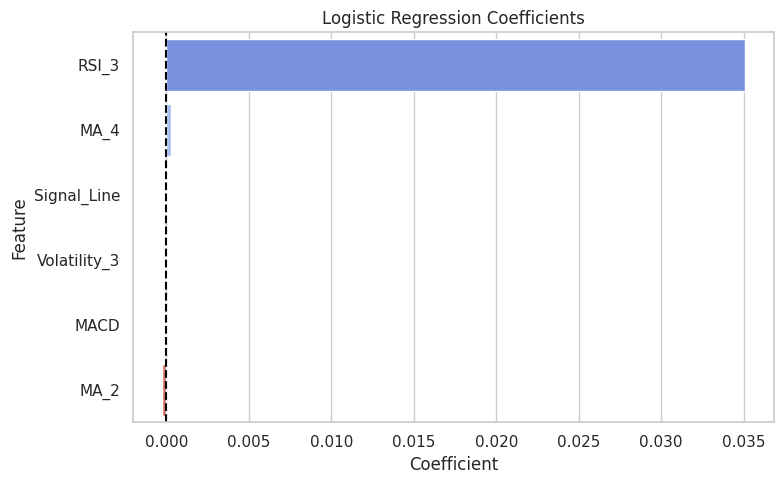

In [39]:
# Get best logistic regression model
best_logreg = best_models["Logistic Regression"]

# Extract coefficients and feature names
coefficients = best_logreg.coef_[0]
features = X_train.columns

# Create a DataFrame
logreg_coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x='Coefficient', y='Feature', data=logreg_coef_df, palette='coolwarm')
plt.axvline(x=0, color='black', linestyle='--')
plt.title("Logistic Regression Coefficients")
plt.tight_layout()
plt.show()


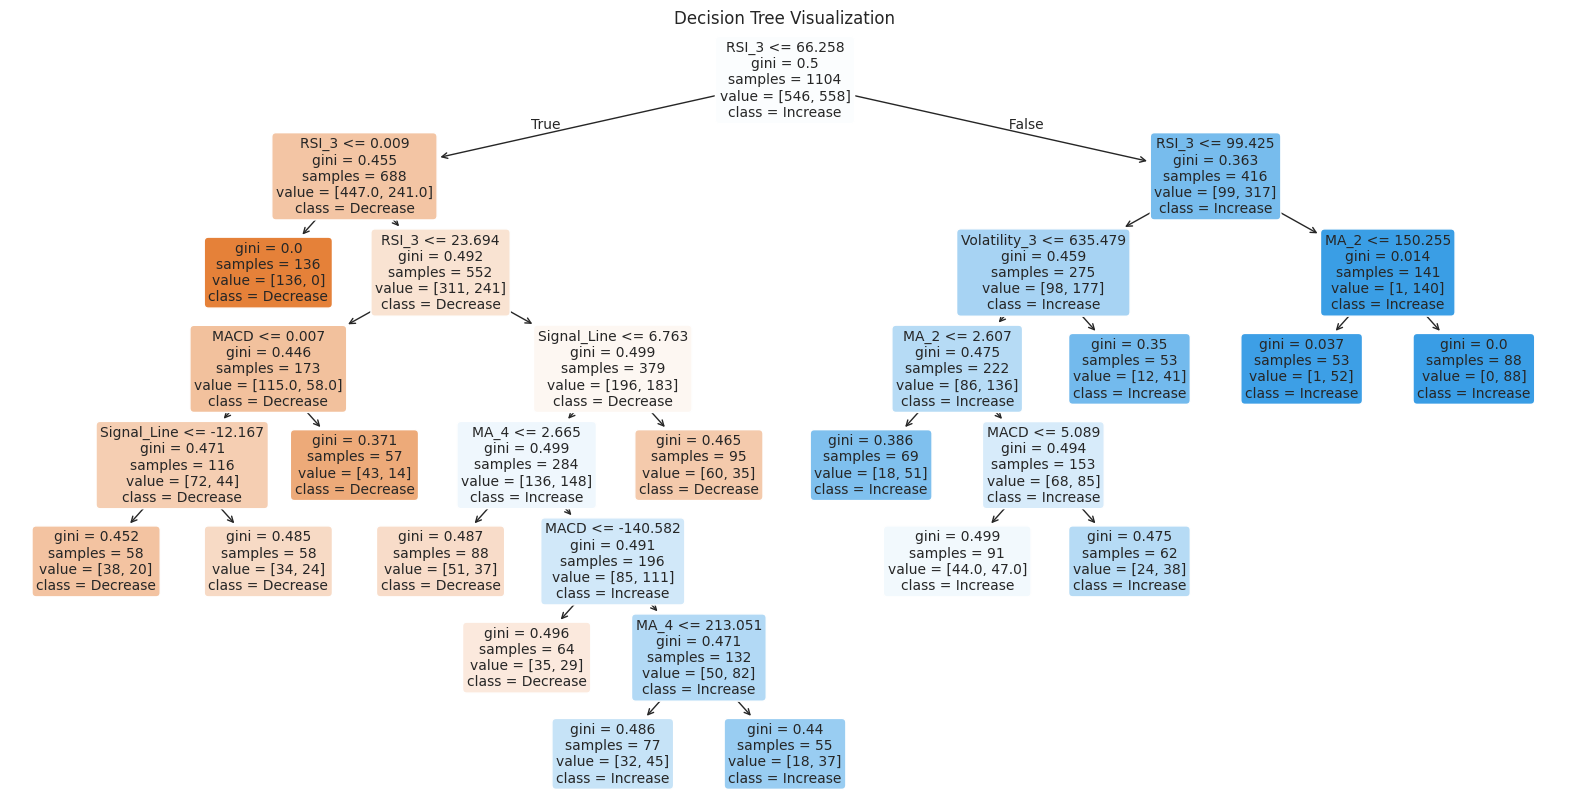

In [36]:
# Retrieve best decision tree model
best_dtree = best_models["Decision Tree"]

plt.figure(figsize=(20, 10))
plot_tree(best_dtree,
          feature_names=X_train.columns,
          class_names=['Decrease', 'Increase'],
          filled=True,
          rounded=True,
          fontsize=10)
plt.title("Decision Tree Visualization")
plt.show()

/tmp/ipython-input-37-3703721117.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=rf_importance_df, palette='crest')


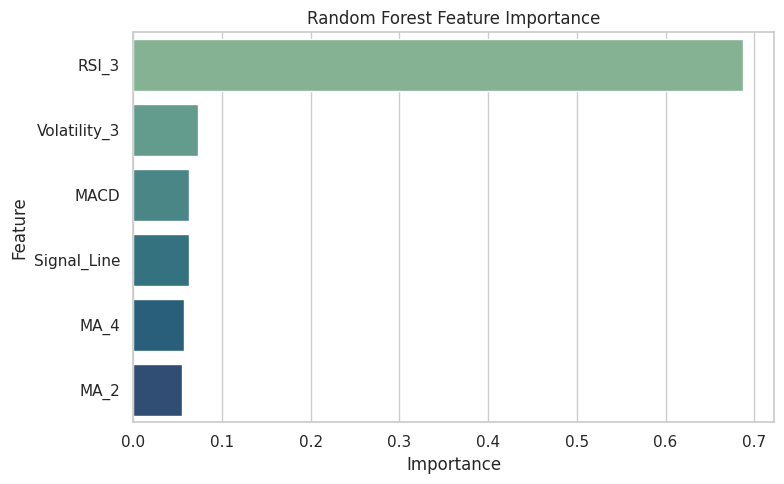

In [37]:
# Get Random Forest model and its feature importances
best_rf = best_models["Random Forest"]
rf_importances = best_rf.feature_importances_

# Create a DataFrame
rf_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=rf_importance_df, palette='crest')
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()


/tmp/ipython-input-38-3525281947.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=xgb_importance_df, palette='viridis')


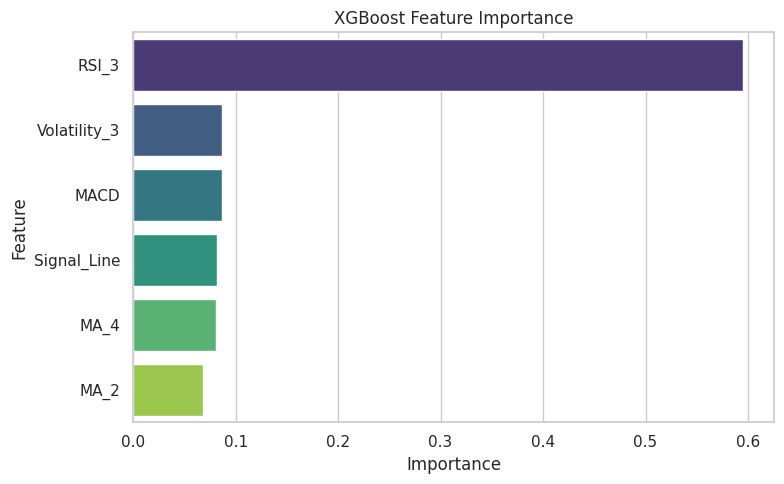

In [38]:
# Get XGBoost model and its feature importances
best_xgb = best_models["XGBoost"]
xgb_importances = best_xgb.feature_importances_

# Create a DataFrame
xgb_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=xgb_importance_df, palette='viridis')
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()
